## Problem Statement

To create a Machine Learning model to detect anomalies in a dataset consisting real time current readings of a 3-phase AC motor (3.2 hp)

#### Approach taken to solve this problem:<br>
<li>The datasets are in 6 files. So combine it into a single source. </li>
<li><b>Data Analysis</b> and <b>Data Visualizations</b> to understand the pattern and distribution of data </li>
<li>Necessary data pre-processing steps to make the data ready for modeling </li>
<li>As there are no target labels, this is an <b>Unsupervised machine learning</b> problem.</li>
<li>Fit the data to <b>KMeans Clustering </b>algorithm and split the data into 2 clusters. </li>
<li>The cluster value can be stored as a target column and now our problem becomes a <b>Classification type</b>. </li>
<li>Now, use the whole dataset along with target column to train and build a classification model (<b>Random Forest Classifier</b>)</li>
<li>Model is saved to a pickle file so that it can be imported and reused with any values. </li>

The steps involved in this task:
1. Loading the tools
2. Loading the dataset
3. Exploratory Data Analysis (EDA)
4. Feature scaling
5. Model Building- KMeans Clustering algorithm
6. Model Evaluation
7. Save the model to a pickle file

## 1. Loading the tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

The data is spread across 6 different files. Combining all 6 files to a single file

In [2]:
import os
os.listdir()

['.ipynb_checkpoints',
 'anomaly-detection-ACmotor.ipynb',
 'dataset',
 'predictions']

In [3]:
os.chdir("dataset")
os.listdir()

['data0 (1).txt',
 'data109.txt',
 'data112.txt',
 'data88.txt',
 'data89.txt',
 'data9.txt']

In [4]:
files = [file for file in os.listdir()]
files

['data0 (1).txt',
 'data109.txt',
 'data112.txt',
 'data88.txt',
 'data89.txt',
 'data9.txt']

In [5]:
files_df = pd.concat(map(pd.read_csv, files), ignore_index=True)
files_df.to_csv("files.csv")

## 2. Loading the dataset

In [6]:
df=pd.read_csv("files.csv").T
df.reset_index(inplace=True)
df.columns.values[0] = "values"
df

,values
0,Unnamed: 0
1,0
2,0.1
3,0.2
4,0.3
...,...
13590,120.2065
13591,248.1193
13592,120.2066
13593,248.1194


In [7]:
df['values'].str.contains('Unnamed').sum()

2

As there is no text (i.e. column name) before the first comma on the first line of the csv file, Unnamed is displayed. So we have to get rid of unnamed.

In [8]:

df["current_readings"] = df["values"].str.split(": ").str[0]
df

,values,current_readings
0,Unnamed: 0,Unnamed
1,0,0
2,0.1,0.1
3,0.2,0.2
4,0.3,0.3
...,...,...
13590,120.2065,120.2065
13591,248.1193,248.1193
13592,120.2066,120.2066
13593,248.1194,248.1194


In [9]:
txt=df[df["current_readings"] == 'Unnamed'].index
txt

Int64Index([0, 10001], dtype='int64')

In [10]:
df.drop(txt,inplace=True)
df.drop("values",axis=1,inplace=True)
df

,current_readings
1,0
2,0.1
3,0.2
4,0.3
5,0.4
...,...
13590,120.2065
13591,248.1193
13592,120.2066
13593,248.1194


In [11]:
df['current_readings'].str.contains('Unnamed').sum()

0

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13593 entries, 1 to 13594
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   current_readings  13593 non-null  object
dtypes: object(1)
memory usage: 212.4+ KB


In [13]:
df["current_readings"] = df["current_readings"].astype(float)

In [14]:
df.dtypes

current_readings    float64
dtype: object

## 3. Exploratory Data Analysis

In [15]:
df.describe()

,current_readings
count,13593.000000
mean,52.371722
std,80.108110
min,0.000000
25%,0.405600
50%,0.711400
75%,120.200500
max,248.999000


<li>Mean = 52.37</li>
<li>Median = 0.71</li>
<li> SD = 80.10</li>

Findings:
<li> There is very gradual increase in values till the Q2 value (Median).</li>
<li> Values in the Third Quartile suddenly increases and there is a wide dispersion</li>
    

### Line graph

Text(0.5, 1.0, 'Current readings')

<Figure size 1800x1200 with 0 Axes>

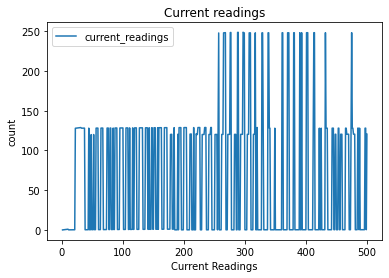

In [16]:
# Visualizing only the first 500 values to view it clearly
plt.figure(dpi=300)

df[:500].plot()
plt.xlabel("Current Readings")
plt.ylabel("count")
plt.title("Current readings")

### Box Plot


Text(0.5, 1.0, 'Box plot')

<Figure size 1800x1200 with 0 Axes>

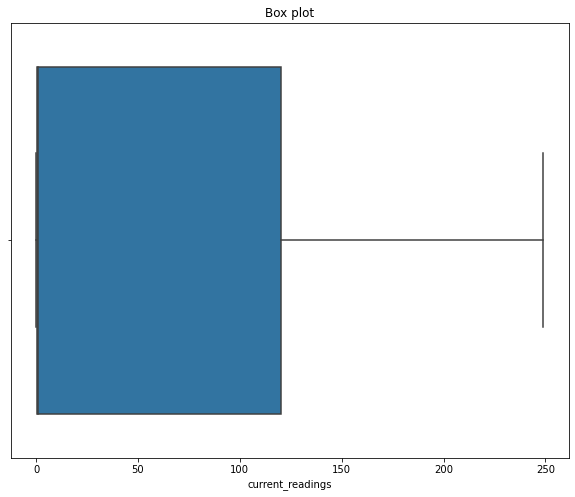

In [17]:
# box plot
plt.figure(dpi=300)
plt.figure(figsize=(10,8))
sns.boxplot(data=df,x='current_readings');
plt.title('Box plot', fontsize = 12)

## Histogram

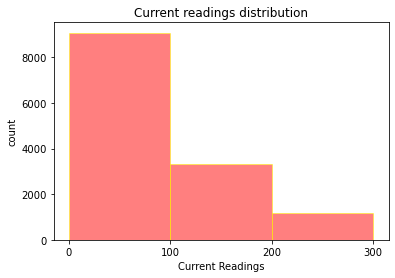

In [18]:
bins=np.arange(0,400,100)
plt.hist(df["current_readings"],bins,facecolor="red",edgecolor="yellow",alpha=0.5);
plt.xticks(bins)
plt.title("Current readings distribution")
plt.xlabel("Current Readings")
plt.ylabel("count")
plt.show()


Findings:
<li>It can be seen that 0 to 120 is the normal range.</li>
<li>Values > 200 are outliers and considered anomaly </li>
<li> The distribution is Right Skewed (Positive Skewness)</li>
    
    

## 4. Feature Scaling

In [19]:
# In order to fit data to the model, it has to be reshaped.
x = np.asarray(df['current_readings'])
x = x.reshape(-1,1)
x

array([[0.000000e+00],
       [1.000000e-01],
       [2.000000e-01],
       ...,
       [1.202066e+02],
       [2.481194e+02],
       [2.481195e+02]])

In [20]:
# Perform Standard Scaling to restrict models from being biased towards features having higher / lower magnitude values.
sc = StandardScaler()
x = sc.fit_transform(x)
x

array([[-0.6537871 ],
       [-0.65253874],
       [-0.65129038],
       ...,
       [ 0.8468228 ],
       [ 2.44363373],
       [ 2.44363498]])

In [21]:
x.shape

(13593, 1)

The data is now pre-processed and ready for modelling.

## 5. Model Building

Apprach for building model:
<li>As there are no target labels, this is an <b>Unsupervised machine learning </b>problem. </li>
<li>Fit the data to KMeans Clustering algorithm and split the data into 2 clusters. </li>
<li>The cluster value can be stored as a target column and now our problem becomes a Classification type.</li>
<li>So use the whole dataset along with target column to train and build a classification model (Random Forest Classifier)</li>

In [22]:
## kmeans clustering algorithm 

kmeans=KMeans(n_clusters=2, init='k-means++', random_state=0)
y = kmeans.fit_predict(x)

In [23]:
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [24]:
kmeans.cluster_centers_

array([[-0.64743859],
       [ 1.3000349 ]])

In [25]:
# append the predicted values to a new column

df["labels"]=kmeans.labels_
df

,current_readings,labels
1,0.0000,0
2,0.1000,0
3,0.2000,0
4,0.3000,0
5,0.4000,0
...,...,...
13590,120.2065,1
13591,248.1193,1
13592,120.2066,1
13593,248.1194,1


The KMeans model has grouped the data into clusters 0 and 1.<br>
It can be interpreted as :
> 0 = no (There is no anomaly) ; 1= yes (This is an anomaly)



In [26]:
# making a copy of df
clustered_df = df.copy()
clustered_df

,current_readings,labels
1,0.0000,0
2,0.1000,0
3,0.2000,0
4,0.3000,0
5,0.4000,0
...,...,...
13590,120.2065,1
13591,248.1193,1
13592,120.2066,1
13593,248.1194,1


In [29]:
# For easy readability of dataset, change the target column to categorical 
clustered_df["anomaly"] = "no"
clustered_df["anomaly"] = np.where(clustered_df["labels"] == 1, "yes", clustered_df["anomaly"])                         
clustered_df.drop("labels",axis=1,inplace=True)
clustered_df


,current_readings,anomaly
1,0.0000,no
2,0.1000,no
3,0.2000,no
4,0.3000,no
5,0.4000,no
...,...,...
13590,120.2065,yes
13591,248.1193,yes
13592,120.2066,yes
13593,248.1194,yes


In [30]:
clustered_df.head()

,current_readings,anomaly
1,0.0,no
2,0.1,no
3,0.2,no
4,0.3,no
5,0.4,no


In [31]:
clustered_df.tail()

,current_readings,anomaly
13590,120.2065,yes
13591,248.1193,yes
13592,120.2066,yes
13593,248.1194,yes
13594,248.1195,yes


In [32]:
# export the dataset to a csv file

clustered_df.to_csv("C:/Users/Kalpagam/udemy_bootcamp/ml_projects/anomaly_detection/predictions/predicted.csv")

Now, readings which are outliers or anomalies are indicated as <b>yes</b> in the "anomaly" column.

Now, the problem has reduced to a <b>classification problem</b>

#### Data preprocessing

In [35]:
## split the dataset as train and test

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df["current_readings"],df["labels"])
x_train.shape, x_test.shape,y_train.shape,y_test.shape

((10194,), (3399,), (10194,), (3399,))

In [44]:
# reshape

x_train=np.asarray(x_train).reshape(-1,1)
y_train=np.asarray(y_train).reshape(-1,1)
x_test=np.asarray(x_test).reshape(-1,1)
y_test=np.asarray(y_test).reshape(-1,1)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((10194, 1), (10194, 1), (3399, 1), (3399, 1))

In [42]:
# classification model building

from sklearn.ensemble import RandomForestClassifier

# Instantiate model
model = RandomForestClassifier(n_jobs=-1)

# Fit the model
model.fit(x_train,y_train)

C:\Users\Kalpagam\AppData\Local\Temp\ipykernel_15376\1544301963.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


RandomForestClassifier(n_jobs=-1)

In [45]:
y_pred = model.predict(x_test)

In [46]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

## 6.  Model Evaluation

In [48]:
model.score(x_test,y_test)

1.0

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test,y_pred))

[[2309    0]
 [   0 1090]]


In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2309
           1       1.00      1.00      1.00      1090

    accuracy                           1.00      3399
   macro avg       1.00      1.00      1.00      3399
weighted avg       1.00      1.00      1.00      3399



### 7. Save the model to a pickle file

The model is saved to a pickle file so that it can be imported and reused

In [57]:
import pickle
file = open('C:/Users/Kalpagam/udemy_bootcamp/ml_projects/anomaly_detection/trained_model.pkl','wb')
pickle.dump(model,file)

In [58]:
model = open('C:/Users/Kalpagam/udemy_bootcamp/ml_projects/anomaly_detection/trained_model.pkl','rb')
trained_model = pickle.load(model)

In [66]:
sample_xtest_values = np.arange(0,150,2).reshape(-1,1)
sample_xtest_values.shape

(75, 1)

giving some random test values to see if it classifies it

In [67]:
result = trained_model.predict(sample_xtest_values)
print("Result:",result)

Result: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
